***METRICS TO EVALUATE SEGMENTATION***

In [16]:
import torch
from unet import *
from camvid_unet import *
import sklearn as sk
from deeplabV3plus.deeplabv3 import DeepLabV3Plus
from deeplab2 import encoders

import metrics
from sklearn.metrics import classification_report
import dataset 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as A
import os
import pandas as pd

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import numpy as np

import cv2
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%config Completer.use_jedi = False

In [17]:
def transformation():  
    transform = [A.RandomCrop(width=256, height=256)]
    return A.Compose(transform)
    

In [18]:
DATA_DIR = './data/CamVid/'
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [19]:
test_data = dataset.Dataset(x_test_dir, y_test_dir, augmentation = None)

In [20]:
###############################################################
#           LOAD THE MODEL THAT YOU WANT TO EVALUATE          #
###############################################################

#model = CamvidUNet(3,12)
model = DeepLabV3Plus(
            encoder_name = "resnet34",
            encoder_depth = 5,
            encoder_weights = "imagenet",
            encoder_output_stride = 16,
            decoder_channels = 256,
            decoder_atrous_rates = (6, 12, 18),
            in_channels = 3,
            classes = 12,
            upsampling = 4)
#model = CamvidUNet(3,12)
#model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('new_camvid/dl_patches2finetune_wce_adam_0001.pth');
model.to(device)
model.eval();

In [6]:
###############################################################
#       USE THE MODEL TO PREDICT OVER THE TEST SET            #
###############################################################

true_masks = []
predicted_masks = []
for n in range(0,len(test_data)):
    
    image, true_mask = test_data[n] #3*360*480, 360*480
    
    image = image.to(device).unsqueeze(0)#1*3*360*480

    output = model(image)#[1, Nclasses, 360, 480]
    output = torch.sigmoid(output)
    output = output.detach().cpu()
    
    output = output.squeeze(0).numpy() #(360, 480, Nclasses)
    
    output_onelayer = np.argmax(output, axis=0)
    true_mask = true_mask.detach().cpu().numpy()
    
    true_masks.append(true_mask)
    predicted_masks.append(output_onelayer) 
    
y_true = np.reshape(true_masks, -1)
y_pred = np.reshape(predicted_masks, -1)

In [21]:
np.unique(y_true) #classe 25 TRAFIC CONE i 28 TUNEL no hi son

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 26.,
       27., 29., 30., 31.], dtype=float32)

In [24]:
classes = pd.read_csv('data/CamVid/class_dict.csv', index_col = 0)
camvid_32classes = classes.index.tolist()
camvid_32classes = np.delete(camvid_32classes, [25, 28])

***1. GENERAL METRICS (PRECISION, RECALL, F1, ACCURACY)***

In [27]:
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

print(classification_report(y_true, y_pred, target_names=camvid_32classes))

                   precision    recall  f1-score   support

           Animal       0.89      0.38      0.53      9402
          Archway       0.43      0.12      0.19     33968
        Bicyclist       0.82      0.53      0.64   1000137
           Bridge       0.94      0.44      0.60     90470
         Building       0.85      0.91      0.88  36615069
              Car       0.78      0.91      0.84   6043741
  CartLuggagePram       0.20      0.13      0.16     53306
            Child       0.61      0.35      0.45     42074
      Column_Pole       0.57      0.57      0.57   1452350
            Fence       0.75      0.74      0.75   1779301
     LaneMkgsDriv       0.70      0.85      0.77   2294790
  LaneMkgsNonDriv       0.00      0.00      0.00      4308
        Misc_Text       0.54      0.49      0.52    755379
MotorcycleScooter       0.65      0.04      0.07     30257
      OtherMoving       0.68      0.63      0.66    483681
     ParkingBlock       0.72      0.56      0.63    553

In [14]:
print('Pixel accuracy is {0:.2f}'.format(sk.metrics.accuracy_score(y_true, y_pred)))

Pixel accuracy is 0.87


***2. CONFUSION MATRIX***

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
dataframe = pd.DataFrame(conf_mat, index = camvid_32classes, columns=camvid_32classes)

<AxesSubplot:>

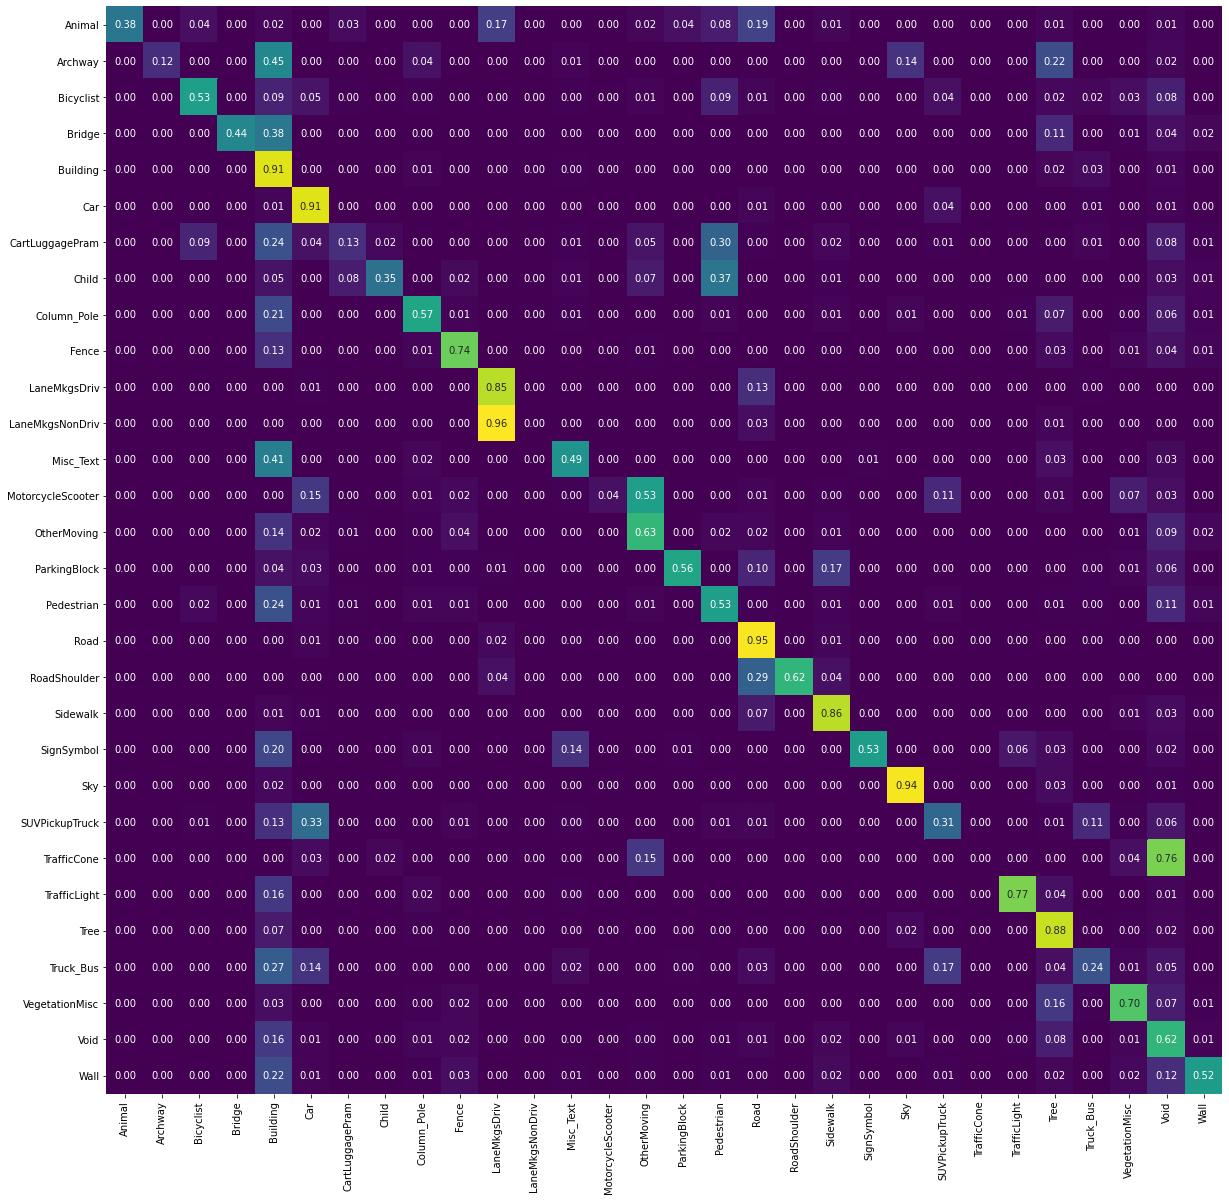

In [43]:
plt.figure(figsize = (20,20))
sn.heatmap(dataframe, annot=True, cmap='viridis',fmt='.2f', cbar=False)

***3. CLASS IoU and mIoU***

In [44]:
conf_mat = confusion_matrix(y_true, y_pred)

In [49]:
pos = conf_mat.sum(1) # positives
res = conf_mat.sum(0) # prediction
tp = np.diag(conf_mat) # true_positives

pixel_acc = tp.sum()/pos.sum()
IoU_array = (tp / (pos + res - tp))

mean_IoU = IoU_array.mean()
weights = [4.86171656e-05, 4.83903258e-04, 4.86921195e-03, 4.36279021e-04,
       2.34876437e-01, 3.21062756e-02, 2.66960509e-04, 3.22721915e-04,
       1.06627111e-02, 1.72131850e-02, 1.92435742e-02, 1.15401692e-04,
       6.75555394e-03, 5.68068068e-05, 4.83085101e-03, 3.62592028e-03,
       6.37439456e-03, 2.93859347e-01, 2.50498482e-03, 7.02825406e-02,
       1.33590849e-03, 1.55695014e-01, 5.44760083e-03, 3.98543705e-05,
       3.73406875e-03, 1.04219909e-01, 1.92255966e-03, 8.43873309e-03, 
       2.70169565e-02, 1.26818795e-02]
weighted_iou = sum([i*j for (i, j) in zip(IoU_array, weights)])

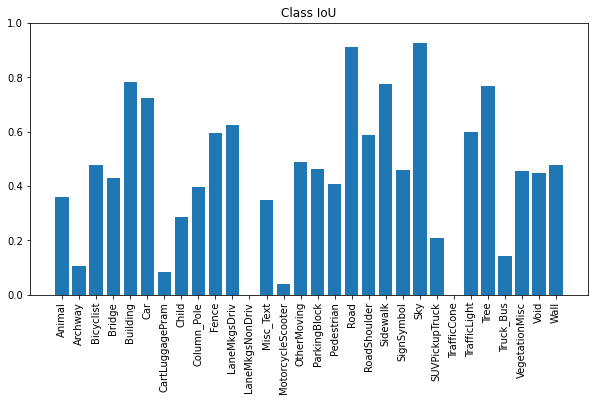

In [50]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.title('Class IoU')
plt.bar(camvid_32classes, IoU_array);

In [51]:
print("Mean IoU: {0:.2f}   Weighted IoU: {1:.2f}".format(mean_IoU, weighted_iou))

Mean IoU: 0.45   Weighted IoU: 0.82


***4. SAMPLE IMAGES***

In [ ]:
#Dataset anterior
def visualize(image, gt_mask):
    colormap = {
    0: [180, 255, 255], #sky
    1: [152, 122, 70], #building
    2: [255, 0, 0], #pole
    3: [168, 168, 168], #road
    4: [253, 153, 51], #pavement
    5: [0, 204, 0], #tree
    6: [255, 255, 0], #signsymbol
    7: [110, 30, 0], #fence
    8: [0, 0, 0], #car
    9: [255, 100, 255], #pedestrian
    10: [50, 70, 255], #bicyclist
    11: [255, 255, 255], #unlabelled 
    }
    gt_mask = gt_mask.detach().cpu().numpy()
    image = image.to(device).unsqueeze(0)#1*3*360*480
    prediction = model(image)#[1, 12, 360, 480]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(12,360, 480)
    prediction = np.argmax(prediction, axis=0)
    
    color_gt = np.zeros((prediction.shape[0],prediction.shape[1],3))
    color_pred = np.zeros((prediction.shape[0],prediction.shape[1],3))
    
    
    
    for c in colormap.keys():
        color_pred[prediction==c] = colormap[c]
        color_gt[gt_mask==c] = colormap[c]
        
    color_gt = np.uint8(color_gt)
    color_pred = np.uint8(color_pred)
        
    return color_gt, color_pred

In [21]:
def visualize_v2(image, gt_mask):
    
    
    classes = pd.read_csv('data/CamVid/class_dict.csv', index_col = 0)
    cls2rgb = {cl:list(classes.loc[cl, :]) for cl in classes.index}
    idx2rgb={idx:tuple(rgb) for idx, (cl, rgb) in enumerate(cls2rgb.items())}
    
    gt_mask = gt_mask.detach().cpu().numpy()
    image = image.to(device).unsqueeze(0)#1*3*360*480
    prediction = model(image)#[1, Nclasses, 360, 480]
    prediction = prediction.detach().cpu().squeeze(0).numpy()#(Nclasses,360, 480)
    prediction = np.argmax(prediction, axis=0)
    
    color_gt = np.zeros((prediction.shape[0],prediction.shape[1],3))
    color_pred = np.zeros((prediction.shape[0],prediction.shape[1],3))
    
    for c in idx2rgb.keys():
        color_pred[prediction==c] = idx2rgb[c]
        color_gt[gt_mask==c] = idx2rgb[c]
        
    color_gt = np.uint8(color_gt)
    color_pred = np.uint8(color_pred)
        
    return color_gt, color_pred

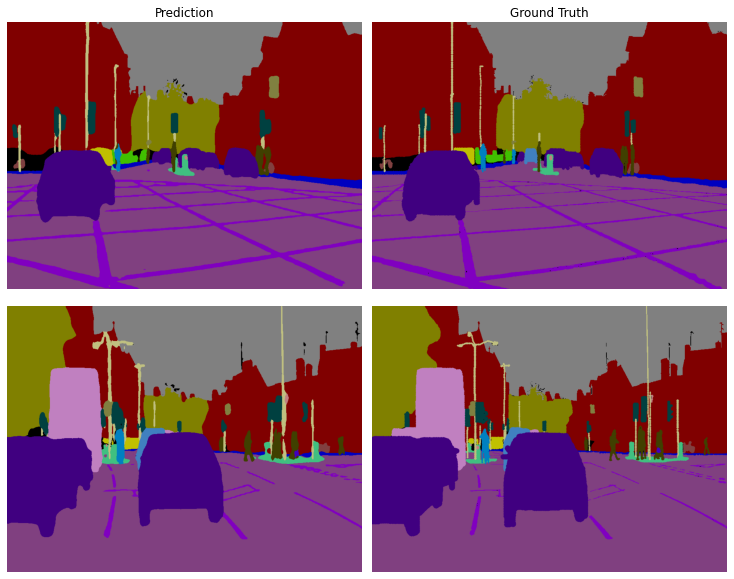

In [28]:
image_1, true_mask_1 = test_data[0]
image_2, true_mask_2 = test_data[1]

vis_gt_1, vis_pred_1 = visualize_v2(image_1, true_mask_1)
vis_gt_2, vis_pred_2 = visualize_v2(image_2, true_mask_2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,8))
ax1.imshow(vis_pred_1)
ax2.imshow(vis_gt_1)
ax3.imshow(vis_pred_2)
ax4.imshow(vis_gt_2)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.set_title('Prediction')
ax2.set_title('Ground Truth')
plt.tight_layout(pad=0, w_pad=1, h_pad=1)

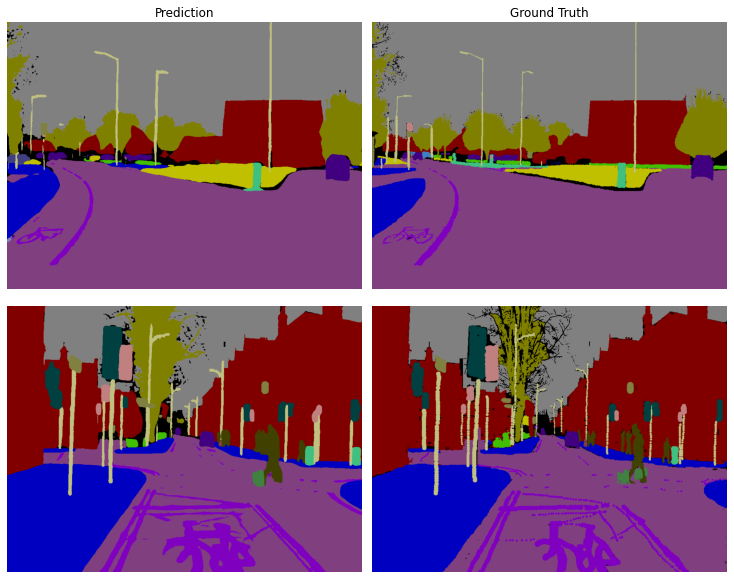

In [27]:
image_1, true_mask_1 = test_data[100]
image_2, true_mask_2 = test_data[101]

vis_gt_1, vis_pred_1 = visualize_v2(image_1, true_mask_1)
vis_gt_2, vis_pred_2 = visualize_v2(image_2, true_mask_2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(10,8))
ax1.imshow(vis_pred_1)
ax2.imshow(vis_gt_1)
ax3.imshow(vis_pred_2)
ax4.imshow(vis_gt_2)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.set_title('Prediction')
ax2.set_title('Ground Truth')
plt.tight_layout(pad=0, w_pad=1, h_pad=1)